# A notebook for segmentation of brace root photos
## J. Cristiano

[Using PlantCV](https://plantcv.readthedocs.io/en/stable/) 

In [1]:
%matplotlib inline
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage import morphology

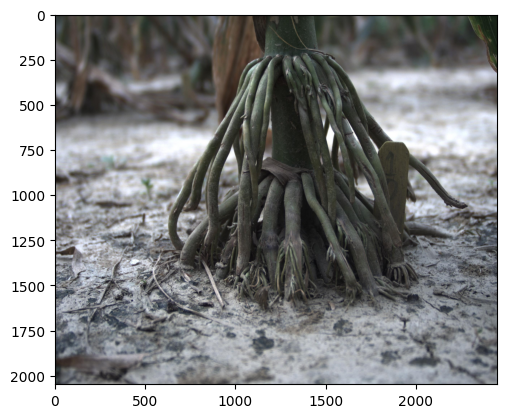

In [2]:
w22_image, _, _ = pcv.readimage("./braceroot_plantcv/w22.jpg",mode="native")
w22_image = np.rot90(w22_image, k=-1)
zmays_image, path_to_zmays, filename_zmays = pcv.readimage("./braceroot_plantcv/288.jpg",mode="native")
zmays_image = np.rot90(zmays_image, k=-2)
pcv.plot_image(zmays_image,cmap=None)

### Attempting color thresholding with Brace root images

The way that plantcv isolates the plant in every image is by having the user set a color threshold (isolating the green colors) and then makes a binary image in which the plant is illuminated white and the rest of the image is cut out (black). "a highpass filter based on the green channel"

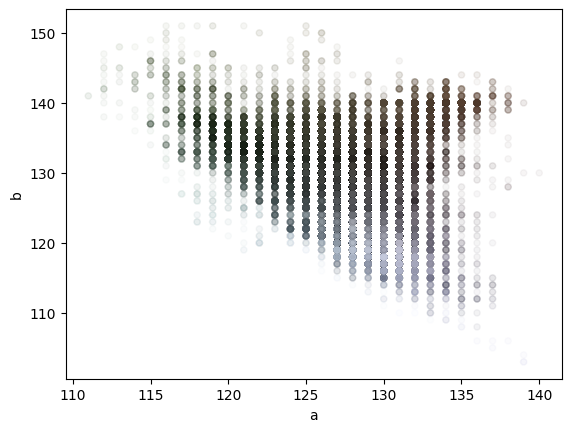

In [3]:
color_scatter = pcv.visualize.pixel_scatter_plot(paths_to_imgs = ["./braceroot_plantcv/288.jpg"] , x_channel = "a", y_channel ="b" )

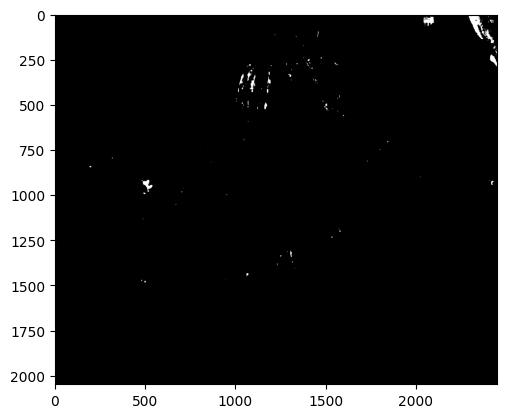

In [32]:
color_thresh = pcv.threshold.dual_channels(rgb_img = zmays_image, x_channel = "a", y_channel = "b", points = [(112,120),(130,165)], above=True)
plt.imshow(color_thresh,cmap="Greys_r")

This doesn't work for multiple reasons, the images are too muddy to begin with making a thresholding line too simple to grab all the green plant pixels, and the plants in the background share the same color so we will never be able to distriguish the foreground from the background.   

### Edge Detection based segmentation 
Sobel edge detection uses a discrete differentiation operator to approximate the gradient of an image and exentuate the edges. (places where the gradient has sharp changes). 

In [5]:
gray_img = cv2.cvtColor(zmays_image, cv2.COLOR_RGB2GRAY)
#apply a gaussian blur and sharpen
gaussian_mays = pcv.gaussian_blur(img=gray_img, ksize=(3, 3), sigma_x=0, sigma_y=None)
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
im = cv2.filter2D(gaussian_mays, -1, kernel)
sb_x_img = pcv.sobel_filter(gray_img=im, dx=1, dy=0, ksize=3)
sb_y_img = pcv.sobel_filter(gray_img=im, dx=0, dy=1, ksize=3)

A long time ago, I wrote my own sobel edge detection function and it worked really well. Lets try it.

In [6]:
def edgeDetectSobel(img):
    #better version of Sobel Filter from Chapter 2 slide 64
    kernel = np.array([[-3,0,3],
                       [-10,0,10],
                       [-3,0,3]])/32
    
    edgeX = np.zeros_like(img) #create arrays for edge data
    edgeY = np.zeros_like(img)
    kernelShape = kernel.shape #tuple of kernel dimensions
    imageShape = img.shape     #tuple of image dimensions
    
    #Zero padding below to add 2 units around the border of the image
    paddedDimensions = (imageShape[0]+kernelShape[0]-1,imageShape[1]+kernelShape[1]-1)
    paddedImage = np.zeros(paddedDimensions)
    for i in range(imageShape[0]):
        for j in range(imageShape[1]):
          paddedImage[i+int((kernelShape[0]-1)/2), j+int((kernelShape[1]-1)/2)] = img[i,j]
    
    #running the Filter
    for i in range(imageShape[0]):   #Create moving window
        for j in range(imageShape[1]):
            window = paddedImage[i:i+kernelShape[0],j:j+kernelShape[1]] #window matrix gathers values from image                            
            edgeX[i,j] = np.sum(window*kernel)#window gets multiplied against the kernel 
            edgeY[i,j] = np.sum(window*np.flip(kernel.T,axis=0))
            
    gradient = np.sqrt(np.square(edgeX) + np.square(edgeY))
    gradient *= 255.0 / gradient.max() #using Gradient equation from Chapter 2 Slide 60
    
    return edgeX, edgeY, gradient


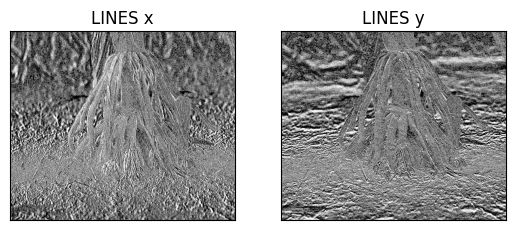

In [7]:
# test1, test2, test3 = edgeDetectSobel(gaussian_mays)
test1, test2, test3 = edgeDetectSobel(im)
plt.subplot(121),plt.imshow(test1,cmap='Greys_r'),plt.title('LINES x')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(test2,cmap='Greys_r'),plt.title('LINES y')
plt.xticks([]), plt.yticks([])
plt.show()

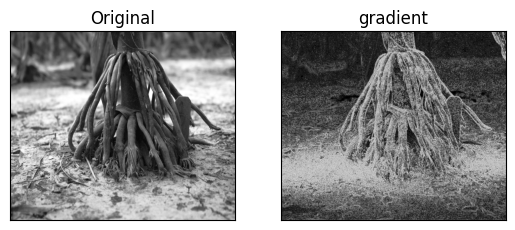

In [8]:
plt.subplot(121),plt.imshow(gaussian_mays,cmap='Greys_r'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(test3,cmap='Greys_r'),plt.title('gradient')
plt.xticks([]), plt.yticks([])
plt.show()

In [9]:
cv2.imwrite("./mays_gradient.jpg",test3)

True

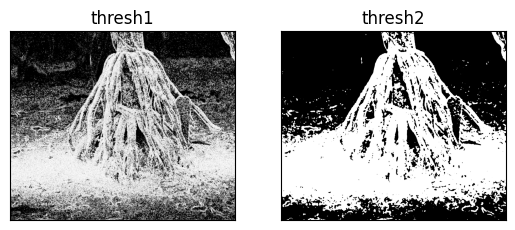

In [10]:
#what if we threshold the gradient image to try and isolate the plant
graydient = test3.astype(np.uint8)
_, thresh1 = cv2.threshold(graydient, 75, 255, cv2.THRESH_BINARY)
blur = cv2.GaussianBlur(thresh1,(25,25),0)
_,thresh2 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.subplot(121),plt.imshow(thresh1,cmap='Greys_r'),plt.title('thresh1')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(thresh2,cmap='Greys_r'),plt.title('thresh2')
plt.xticks([]), plt.yticks([])
plt.show()
# cv2.imwrite("./mays_gradient.jpg",thresh1)

This helps to cut some of the background out of the image, but: 
- There is still soil in the image
- We have a decent outline but still far from a plant mask usable for plantCV
- This most definitely won't work on images with more than one plant in the image        


However, if this image had depth then we could possibly implement a 2nd pair of partial derivatives to the gradient. The gradient of depth would further define each individual brace root and allow us to more easily filter the background. 


Quick question... What happens when you convolve this image with the original?

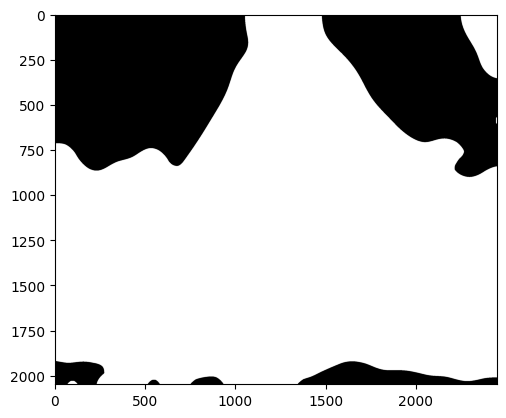

In [51]:
kernel = np.ones((25,25))
mikasa = thresh2
for i in range(3):
    mikasa = cv2.filter2D(mikasa, -1, kernel)
    mikasa = cv2.medianBlur(mikasa,99)
    # mikasa = cv2.filter2D(mikasa, -1, kernel/15)
    _, mikasa = cv2.threshold(mikasa, 200, 255, cv2.THRESH_BINARY)    
plt.imshow(mikasa,cmap="Greys_r")

In [46]:
result = np.zeros_like(zmays_image)
for i in range(3):
    result[:,:,i] = zmays_image[:,:,i] * (255*mikasa) 

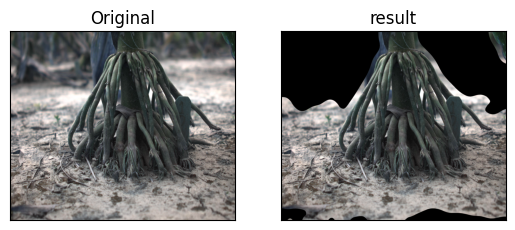

In [47]:
plt.subplot(121),plt.imshow(zmays_image,cmap=None),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(result,cmap=None),plt.title('result')
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
#now we have to create a function for this 
def isolate_brace_roots(img):
    #remove gaussian noise
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gaussian_gray = cv2.GaussianBlur(gray_img,(3,3),0)
    sharp_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    im_denoize = cv2.filter2D(gaussian_gray, -1, sharp_kernel)
    #Detect edges 
    _, _, edges = edgeDetectSobel(im_denoize)
    # _, mask = cv2.threshold(edges.astype(np.uint8), 200, 255, cv2.THRESH_BINARY)
    blur = cv2.GaussianBlur(edges.astype(np.uint8),(11,11),0)
    _, mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #fill in the plant mask
    fill_kernel = np.ones((15,15)) #removes pepper
    for i in range(3):
        mask = cv2.filter2D(mask, -1, fill_kernel)
        mask = cv2.medianBlur(mask,99)
        _, mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)
    #apply plant mask to image
    ret = np.zeros_like(img)
    for i in range(3):
        ret[:,:,i] = img[:,:,i] * (255*mask)
    return ret

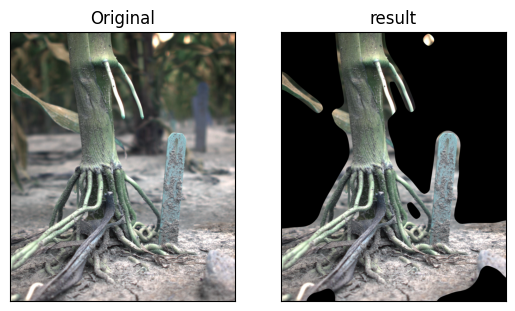

In [ ]:
plt.subplot(121),plt.imshow(w22_image,cmap=None),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(isolate_brace_roots(w22_image),cmap=None),plt.title('result')
plt.xticks([]), plt.yticks([])
plt.show()


Now we have to tune this process to work for all brace root images... oof. 

I've also been experimenting with Root painter and getting mixed, yet promising, results. Root painter still struggles a bit with the background of the pciture. Below are some cherry picked examples.

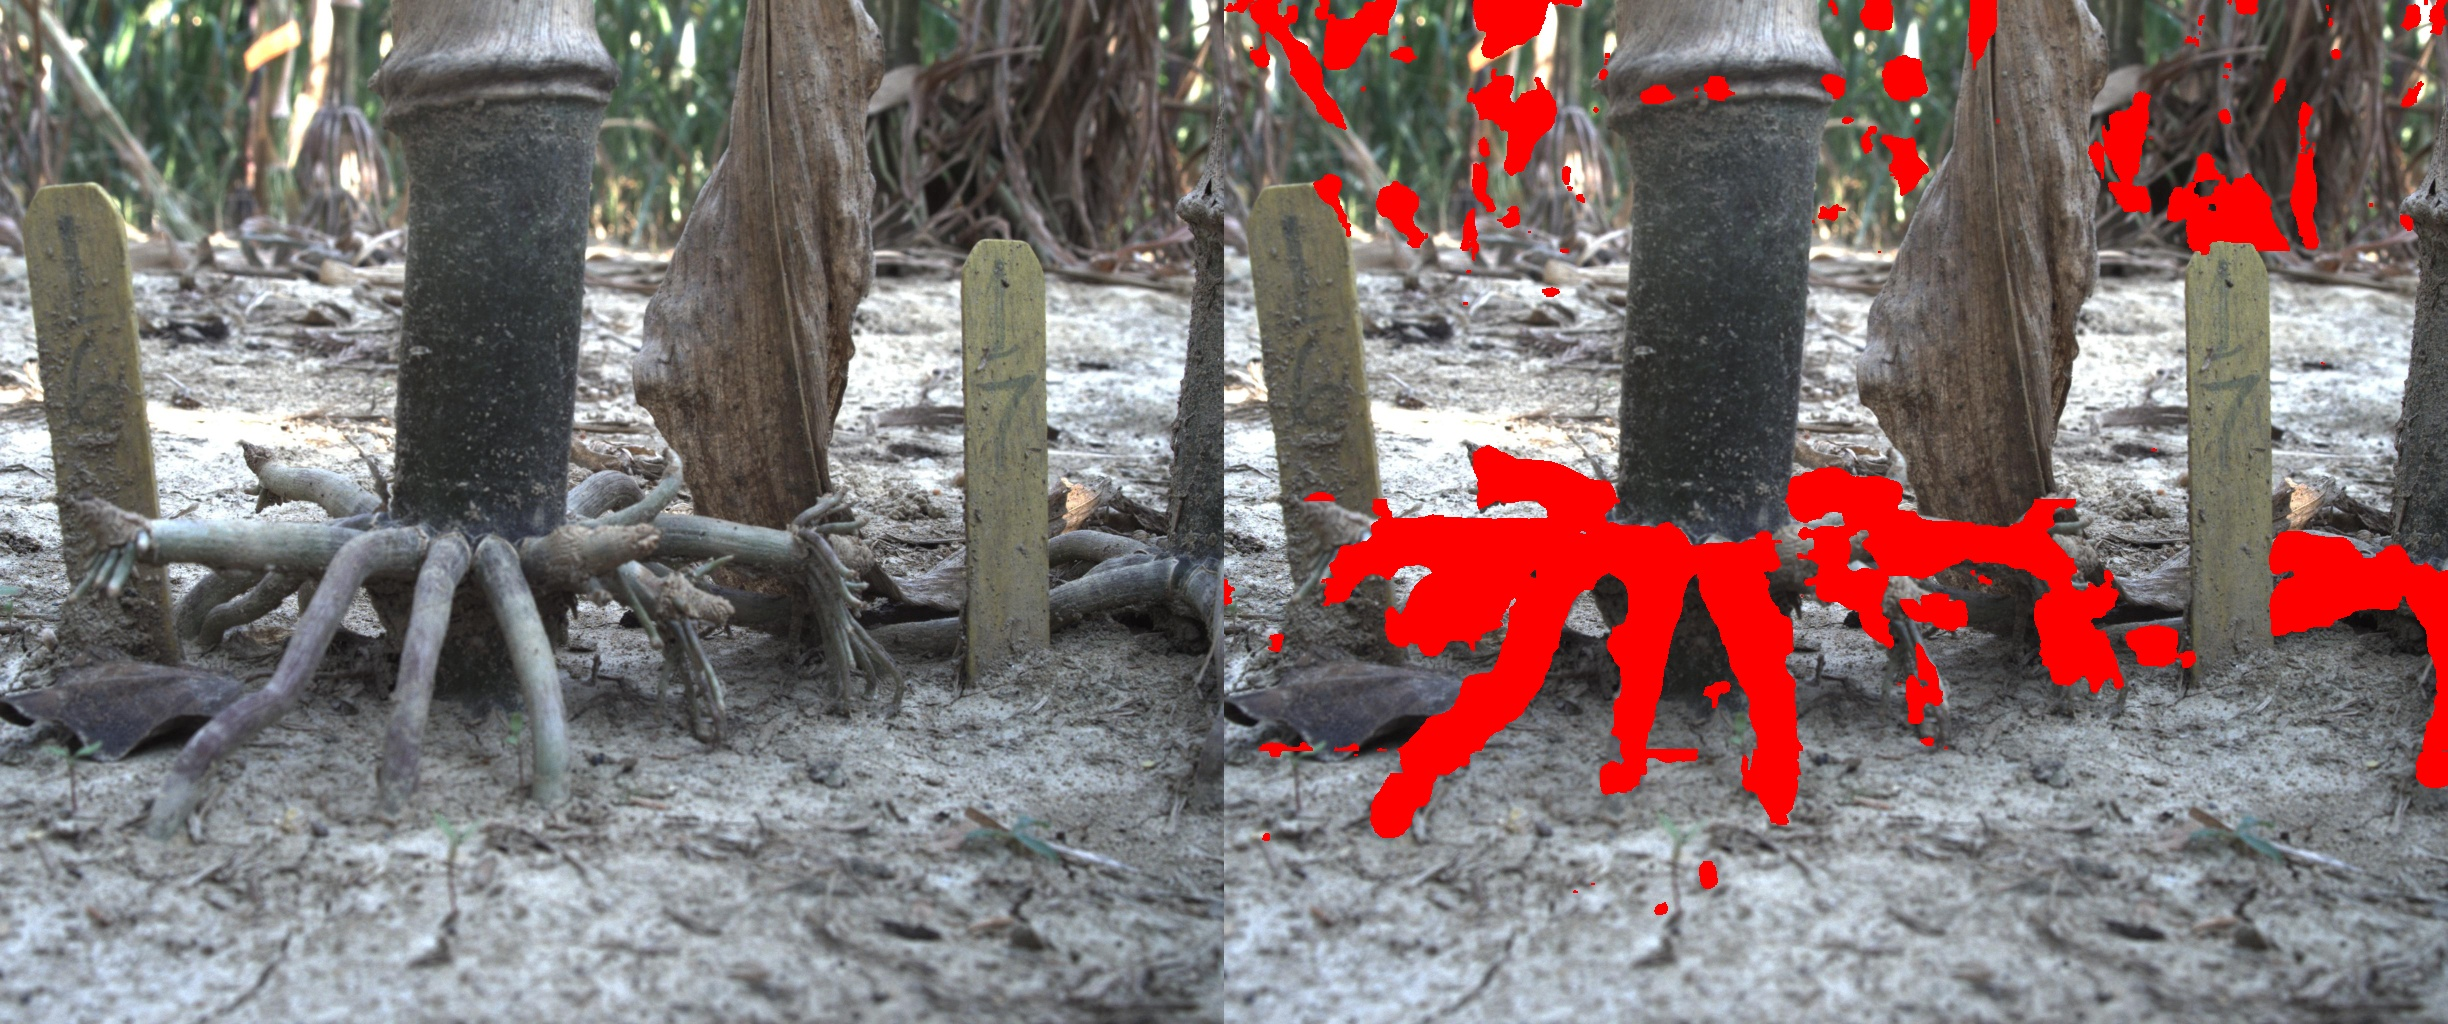

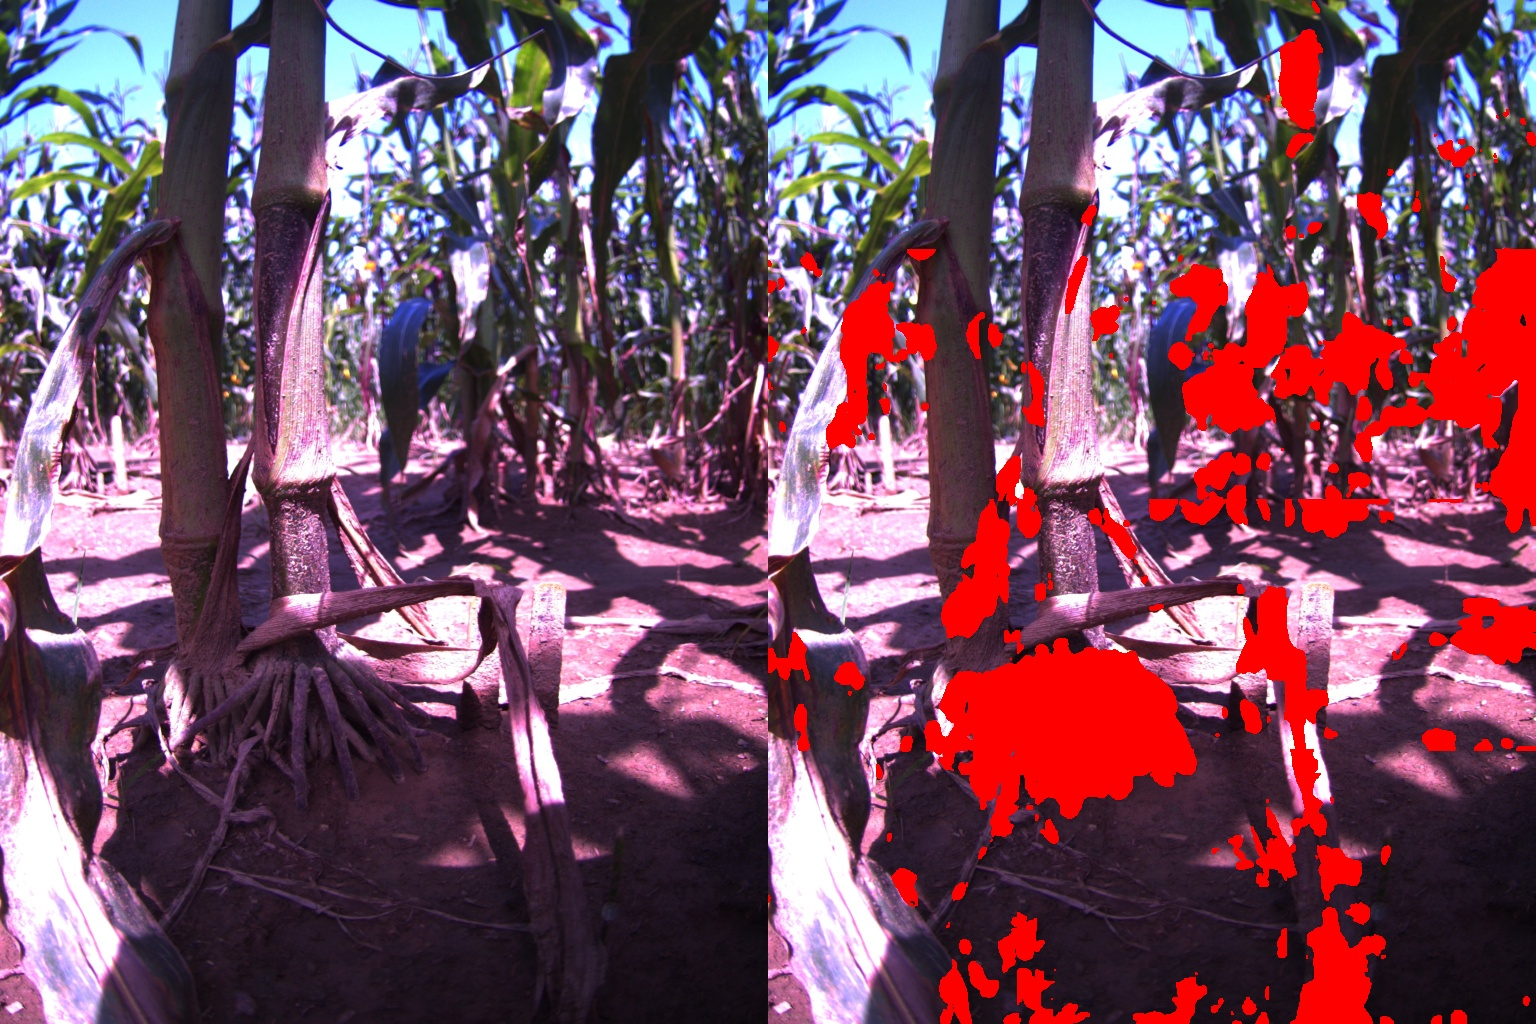



Note: once plant masks are reliable, look into pcv.watershed_segmentation